In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.cluster.vq import kmeans as kmeanss
from scipy.cluster.vq import vq as vqs
from sklearn.metrics import confusion_matrix 
from math import sqrt
from scipy.stats import norm as detnorm

import math
from matplotlib.mlab import PCA
import numpy as np
import numpy.linalg as linalg
from random import sample
import csv
import copy
import os
import glob

In [28]:
def Normalize (Input):
    In = np.array(Input)
    mn = In.mean(axis = 0)
    print(mn)
    var = In.var(axis = 0)
    x = In.shape[0]
    ans = np.zeros((x,2))
    for i in range(x):
        ans[i] = np.subtract(In[i],mn)
        ans[i] = np.divide(ans[i],var)
    return ans

In [29]:
def ROC (P,T):
    inc = 0.001
    n = np.size(P,0)
    m = np.size(P,1)
    TPR = np.zeros(1000) # change accordingly with inc
    FPR = np.zeros(1000)
    i = 0
    #print(n)
    for tet in np.arange(0.0, 1.0, inc):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for cls in range(m):
            #print(cls)
            for data in range(n):
                if ((T[data] == cls) and (P[data][cls] >= tet)):
                    TP = TP + 1
                if ((T[data] == cls) and (P[data][cls] <= tet)):
                    FN = FN + 1
                if ((T[data] != cls) and (P[data][cls] >= tet)):
                    FP = FP + 1
                if ((T[data] != cls) and (P[data][cls] <= tet)):
                    TN = TN + 1
        TPR[i] = TP/(TP + FN)
        FPR[i] = FP/(FP + TN)     
        i = i + 1
    plt.plot(FPR,TPR)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    
def ROCmodf (P,T,num):
    mini = np.amin(P)
    maxi = np.amax(P)
    inc = (maxi-mini)/num
    n = np.size(P,0)
    m = np.size(P,1)
    TPR = np.zeros(num+2) # change accordingly with inc
    FPR = np.zeros(num+2)
    i = 0
    #print(n)
    for tet in np.arange(mini,maxi+inc,inc):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for cls in range(m):
            #print(cls)
            for data in range(n):
                if ((T[data] == cls) and (P[data][cls] >= tet)):
                    TP = TP + 1
                if ((T[data] == cls) and (P[data][cls] <= tet)):
                    FN = FN + 1
                if ((T[data] != cls) and (P[data][cls] >= tet)):
                    FP = FP + 1
                if ((T[data] != cls) and (P[data][cls] <= tet)):
                    TN = TN + 1
        TPR[i] = TP/(TP + FN)
        FPR[i] = FP/(FP + TN)   
        i = i + 1
    plt.plot(FPR,TPR)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    
def DETmodf (P,T,num):
    dnorm = lambda t:(detnorm.ppf(t))
    mini = np.amin(P)
    maxi = np.amax(P)
    inc = (maxi-mini)/num
    n = np.size(P,0)
    m = np.size(P,1)
    FPR = np.zeros(num+2) # change accordingly with inc
    FNR = np.zeros(num+2)
    i = 0
    #print(inc)
    for tet in np.arange(mini,maxi+inc,inc):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for cls in range(m):
            for data in range(n):
                if ((T[data] == cls) and (P[data][cls] >= tet)):
                    TP = TP + 1
                if ((T[data] == cls) and (P[data][cls] <= tet)):
                    FN = FN + 1
                if ((T[data] != cls) and (P[data][cls] >= tet)):
                    FP = FP + 1
                if ((T[data] != cls) and (P[data][cls] <= tet)):
                    TN = TN + 1
        FNR[i] = FN/(TP + FN)
        FPR[i] = FP/(FP + TN)     
        i = i + 1
    FPR1 = (np.array([dnorm(xi) for xi in FPR]))
    FNR1 = (np.array([dnorm(xi) for xi in FNR]))
    #print(FPR1)
    #print(FNR1)
    #detection_error_tradeoff(FPR1,FNR1)
    plt.plot(FPR1,FNR1)
    plt.show()

In [77]:
def func2(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes =["a","ai","cha","la","da"] 
   # classes=["highway","mountain","forst","str","insc"]
    classes =["a","ai","cha","la","da"] 
    #classes =[","cha","la","da"] 
    #classes =["0","1"] 
    # classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [35]:
def dist(a,b):
    n = np.size(a)
    d =0
    #print(n)
    if n!=1:
        for i in range(n):
            d = d + (a[i]-b[i])**2
    else:
        d = (a-b)**2
    return sqrt(d)

In [36]:
sypath = r'/home/moiz/Documents/PRMLlab4/6'
trdata = np.loadtxt(sypath+"/train.txt",delimiter=",")
y_trdata = np.reshape(trdata[:,2],(-1,1))
X_trdata = trdata[:,0:2]
# data1=data[np.nonzero(labels[:,0]==1)]
# sydata1=pd.DataFrame(data1,index=None)
# sydata1=sydata1.loc[:,0:1]

# data2=data[np.nonzero(labels[:,0]==2)]
# sydata2=pd.DataFrame(data2,index=None)
# sydata2=sydata2.loc[:,0:1]

# sydata1.reset_index()
# sydata2.reset_index()

tedata = np.loadtxt(sypath+"/dev.txt",delimiter=",")
y_tedata = np.reshape(tedata[:,2],(-1,1))
X_tedata = tedata[:,0:2]

# data1=data[np.nonzero(labels[:,0]==1)]
# syddata1=pd.DataFrame(data1,index=None)
# syddata1=syddata1.loc[:,0:1]
# data2=data[np.nonzero(labels[:,0]==2)]
# syddata2=pd.DataFrame(data2,index=None)
# syddata2=syddata2.loc[:,0:1]
# syddata1.reset_index()
# syddata2.reset_index()

In [37]:
print(X_tedata.shape)

(1000, 2)


In [38]:
##classes indexed from 0

In [39]:
def find_class(distances,c):
    votes = [0]*c;
    for x in distances:
        votes[x.second]+=1
    return max(enumerate(votes), key=itemgetter(1))
    

In [40]:
# def knn(tr_data,te_data,c):
#     #tr_data list of data arrays indexed at 0
#     tr_dim = np.shape(tr_data)
#     #te_data list of data
#     te_dim = np.shape(te_data)
#     for t in te_data:
#         distances = []
#         for i in range(c):
#             for tr in tr_data[i]:
#                 distances.append(make_pair(dist(tr,t) , i))
#         distances.sort(key = lambda x: x[0])
#         classified,votes = find_class(distances,c)
#         print(classified)

In [41]:
import operator
def euclidianDistance(sample1, sample2):
    distance = 0
    length = np.shape(sample1)[0]
    for x in range(length):
        distance += pow(sample1[x] - sample2[x], 2)
    return math.sqrt(distance)

def getNeighbors(train_set, test_sample, k,tr_labels):
    distances = []
    neighbors = []
    for x in range(len(train_set)):
        dist = euclidianDistance(test_sample, train_set[x])
        distances.append((train_set[x],tr_labels[x],dist))
        #print(distances[x][1])
    distances.sort(key=operator.itemgetter(2))

    for x in range(k):
        neighbors.append([distances[x][0],distances[x][1]])
    return neighbors


In [42]:
def getResponse(neighbors,c):
    classVotes = {}
    for x in range(len(neighbors)):
        response = int(neighbors[x][1])
        #print(response)
        if response in classVotes:
            classVotes[response] += 1
        else:
            classVotes[response] = 1
    #print(classVotes)
    prob = np.zeros(c)
    sum=0
    for i in range(c):
        if i+1 in classVotes:
            sum +=classVotes[i+1]
            prob[i]=classVotes[i+1]
        else:
            sum=sum
            prob[i]=0
    if(sum==0):
        print("shit")
        print(classVotes)
    for i in range(c):
        prob[i]/=sum
    sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)
    #print(neighbors)
    return sortedVotes[0][0],prob

In [43]:
def getAccuracy(testSet, predictions):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x] == predictions[x]:
            correct += 1
    return round((correct/float(len(testSet))) * 100.0, 3)

In [44]:
def knn(k,c,test_data, train_data,tr_labels):
    print('************    K = ', k , '  ******************')
    #copy_of_test_data = test_data.copy()
    copy_of_train_data = train_data
    predictions = []
    probab=[]
    print('--> Calculating KNN...')
    for test_sample in test_data:
        #print(test_sample[0], ', ', test_sample[1])
        neighbors = getNeighbors(copy_of_train_data, test_sample, k,tr_labels)
        neighbors_prediction,p= getResponse(neighbors,c)
        #print(neighbors_prediction)
        predictions.append(neighbors_prediction)
        probab.append(p)
        #break
    #print(predictions)
#     print('--> Calculating Accuracy...')
#     accuracy = getAccuracy(te_labels,predictions)
#     print('Accuracy = ', accuracy, '%')
    return probab,predictions

In [22]:
k=3

In [23]:
tprobabs,Predicted = knn(3,2,X_tedata,X_trdata,y_trdata)

************    K =  3   ******************
--> Calculating KNN...


In [183]:
Predicted

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [189]:
getAccuracy(y_tedata,Predicted)

100.0

Text(0.5, 1.0, 'Decision boundary and Surface k=3 kNN syn')

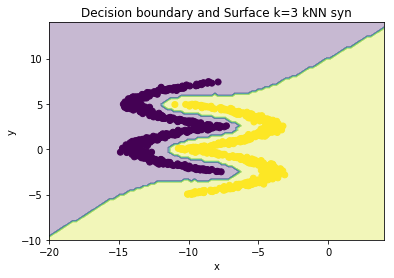

In [184]:
nx,ny = 100,100

y = np.linspace(-10,14,ny)
x = np.linspace(-20,4,nx)
A,B = np.meshgrid(x,y)
z = np.zeros((nx,ny))
for i in range(nx):
    #print(i)
    for j in range(ny):
        neighbors = getNeighbors(X_trdata,[A[i,j],B[i,j]], k,y_trdata)
        neighbors_prediction,p= getResponse(neighbors,2)
        z[i,j] = neighbors_prediction

        
plt.xlabel("x")
plt.ylabel("y")
#plt.xlim(x_l,x_r)

plt.contourf(A,B,z,alpha=0.3)
plt.scatter(tedata[:,0],tedata[:,1],c =tedata[:,2] )
plt.title("Decision boundary and Surface k=3 kNN syn")
#plt.savefig('NN-synthetic-decision-998-2hidden.jpg')

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

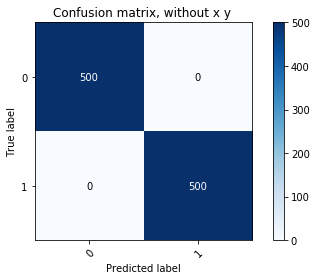

In [196]:


T=np.full(500,1,dtype='int')
T = np.concatenate((T,np.full(500,2,dtype='int')))


print(T)

func2(T,Predicted,classes=["1","2","3"],title='Confusion matrix, without x y ')


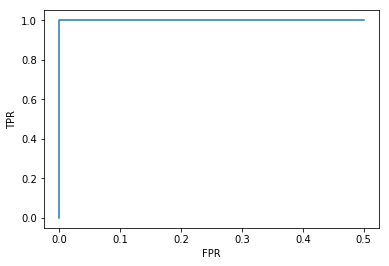

In [26]:

T=np.full(500,0,dtype='int')
T = np.concatenate((T,np.full(500,1,dtype='int')))
ROCmodf(tprobabs,T,100)

In [45]:
trainfiles = glob.glob('/home/moiz/Documents/PRMLlab4/*/train/*.jpg_color_edh_entropy',recursive=True)
testfiles = glob.glob('/home/moiz/Documents/PRMLlab4/*/dev/*.jpg_color_edh_entropy',recursive=True)
def load_data(files):
    data =[]
    for i in files:
        data+=[np.reshape(np.loadtxt(i),(-1))]
    return np.array(data)
X_itrdata = load_data(trainfiles)
X_itedata = load_data(testfiles)

In [46]:
mapping = {}
mapping['highway'] = 1
mapping['mountain'] = 2
mapping['forest'] = 3
mapping['street'] = 4
mapping['insidecity'] = 5
y_itrdata=[]
for i in trainfiles:
    x = np.zeros(1)
    x[0]=mapping[(i.split('/')[5])]
    y_itrdata.append(x)
y_itrdata=np.array(y_itrdata)

y_itedata=[]
for i in testfiles:
    x = np.zeros(1)
    x[0]=mapping[(i.split('/')[5])]
    y_itedata.append(x)
y_itedata=np.array(y_itedata)

************    K =  2   ******************
--> Calculating KNN...
************    K =  3   ******************
--> Calculating KNN...
************    K =  4   ******************
--> Calculating KNN...
************    K =  5   ******************
--> Calculating KNN...
************    K =  6   ******************
--> Calculating KNN...
************    K =  7   ******************
--> Calculating KNN...
************    K =  8   ******************
--> Calculating KNN...
************    K =  9   ******************
--> Calculating KNN...
************    K =  10   ******************
--> Calculating KNN...
************    K =  11   ******************
--> Calculating KNN...
************    K =  12   ******************
--> Calculating KNN...
************    K =  13   ******************
--> Calculating KNN...
************    K =  14   ******************
--> Calculating KNN...


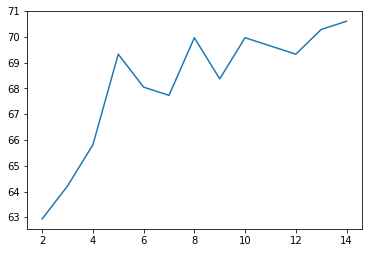

In [264]:
Accu = []
K=[]
for k in range(2,15):
        probab,Predicted = knn(k,5,X_itedata,X_itrdata,y_itrdata)
        Accu.append(getAccuracy(y_itedata,Predicted))
        K.append(k)
plt.plot(K,Accu)
plt.show()

In [57]:
probab,Predicted = knn(14,5,X_itedata,X_itrdata,y_itrdata)

************    K =  14   ******************
--> Calculating KNN...


In [58]:
getAccuracy(y_itedata,Predicted)

70.607

In [67]:
Tv = np.zeros(5)
for i in range(np.shape(y_itedata)[0]):
    if(y_itedata[i][0]==1):
        Tv[0]=Tv[0]+1
    if(y_itedata[i][0]==2):
        Tv[1]=Tv[1]+1
    if(y_itedata[i][0]==3):
        Tv[2]=Tv[2]+1
    if(y_itedata[i][0]==4):
        Tv[3]=Tv[3]+1
    if(y_itedata[i][0]==5):
        Tv[4]=Tv[4]+1
    



T=np.full(int(Tv[0]),0,dtype='int')
T = np.concatenate((T,np.full(int(Tv[1]),1,dtype='int')))
T = np.concatenate((T,np.full(int(Tv[2]),2,dtype='int')))
T = np.concatenate((T,np.full(int(Tv[3]),3,dtype='int')))
T = np.concatenate((T,np.full(int(Tv[4]),4,dtype='int')))

In [68]:
T.shape
np.array(Predicted).shape

(313,)

In [69]:
np.array(probab).shape

(313, 5)

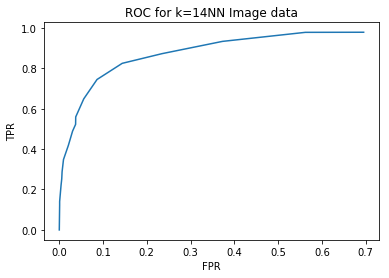

In [70]:
plt.title("ROC for k=14NN Image data")
ROCmodf(probab,T,200)

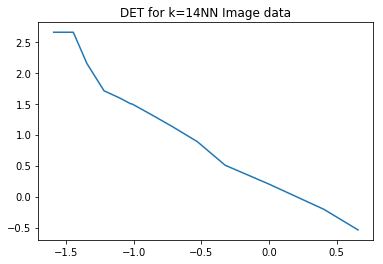

In [66]:
plt.title("DET for k=14NN Image data")

DETmodf(probab,T,100)

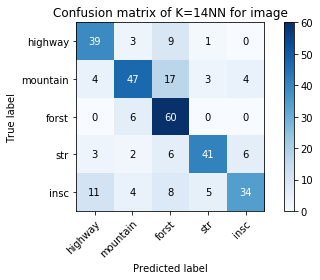

In [64]:

T=np.full(int(Tv[0]),1,dtype='int')
T = np.concatenate((T,np.full(int(Tv[1]),2,dtype='int')))
T = np.concatenate((T,np.full(int(Tv[2]),3,dtype='int')))
T = np.concatenate((T,np.full(int(Tv[3]),4,dtype='int')))
T = np.concatenate((T,np.full(int(Tv[4]),5,dtype='int')))
func2(T,Predicted,classes=["1","2","3"],title='Confusion matrix of K=14NN for image')

In [82]:
trainfiles = glob.glob('/home/moiz/Documents/PRML3/*/train/*.mfcc',recursive=True)
testfiles = glob.glob('/home/moiz/Documents/PRML3/*/dev/*.mfcc',recursive=True)
def redundancy_v(files,res_dim):
    train = []
    traincounts = []
    for e in files:
        a = np.loadtxt(e,skiprows=1)
        curr = int(a.shape[0])
        res = []
        for i in range(int(curr)):
            res += list(np.tile(a[i],(res_dim//curr + int(res_dim%curr>i))))
        train+=[np.array(res)]
        traincounts+=[curr]
    return train,traincounts

X_vtrdata,_ = redundancy_v(trainfiles,194)
X_vtedata,_ = redundancy_v(testfiles,194)
X_vtrdata = np.array(X_vtrdata)
X_vtedata = np.array(X_vtedata)

# #not useful
# from sklearn.decomposition import PCA
# # pca = PCA(6)
# X = pca.fit_transform(X)
# devX = pca.transform(devX)

mapping = {}
mapping['o'] = 1.
mapping['1'] = 2.
mapping['4'] = 3.
mapping['z'] = 4.
mapping['6'] = 5.
y_vtrdata=[]
for i in trainfiles:
    x = np.zeros(1)
    x[0]=mapping[(i.split('/')[5])]
    y_vtrdata.append(x)
y_vtrdata=np.array(y_vtrdata)

y_vtedata=[]
for i in testfiles:
    x = np.zeros(1)
    x[0]=mapping[(i.split('/')[5])]
    y_vtedata.append(x)
y_vtedata=np.array(y_vtedata)

************    K =  2   ******************
--> Calculating KNN...
************    K =  3   ******************
--> Calculating KNN...
************    K =  4   ******************
--> Calculating KNN...
************    K =  5   ******************
--> Calculating KNN...
************    K =  6   ******************
--> Calculating KNN...
************    K =  7   ******************
--> Calculating KNN...
************    K =  8   ******************
--> Calculating KNN...
************    K =  9   ******************
--> Calculating KNN...


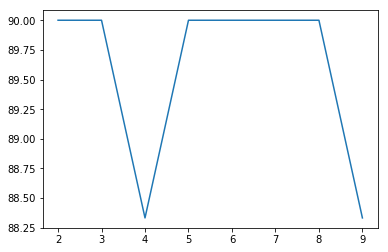

In [84]:
Accu = []
K=[]
for k in range(2,10):
        probab,Predicted = knn(k,5,X_vtedata,X_vtrdata,y_vtrdata)
        Accu.append(getAccuracy(y_vtedata,Predicted))
        K.append(k)
plt.plot(K,Accu)
plt.show()

In [85]:
probab,Predicted = knn(6,5,X_vtedata,X_vtrdata,y_vtrdata)

getAccuracy(y_vtedata,Predicted)

************    K =  6   ******************
--> Calculating KNN...


90.0

In [89]:
Tv = np.zeros(5)
for i in range(np.shape(y_vtedata)[0]):
    if(y_vtedata[i][0]==1):
        Tv[0]=Tv[0]+1
    if(y_vtedata[i][0]==2):
        Tv[1]=Tv[1]+1
    if(y_vtedata[i][0]==3):
        Tv[2]=Tv[2]+1
    if(y_vtedata[i][0]==4):
        Tv[3]=Tv[3]+1
    if(y_vtedata[i][0]==5):
        Tv[4]=Tv[4]+1
T=np.full(int(Tv[0]),0,dtype='int')
T = np.concatenate((T,np.full(int(Tv[1]),1,dtype='int')))
T = np.concatenate((T,np.full(int(Tv[2]),2,dtype='int')))
T = np.concatenate((T,np.full(int(Tv[3]),3,dtype='int')))
T = np.concatenate((T,np.full(int(Tv[4]),4,dtype='int')))

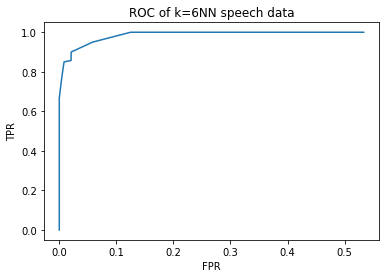

In [90]:
plt.title("ROC of k=6NN speech data")
ROCmodf(probab,T,100)

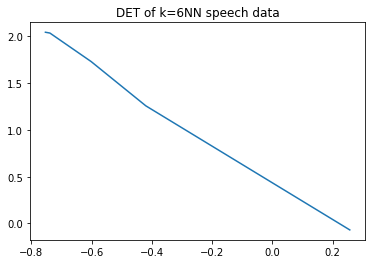

In [93]:
plt.title("DET of k=6NN speech data")
DETmodf(probab,T,50)

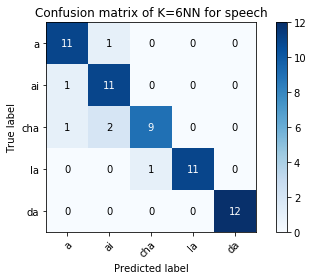

In [92]:

T=np.full(int(Tv[0]),1,dtype='int')
T = np.concatenate((T,np.full(int(Tv[1]),2,dtype='int')))
T = np.concatenate((T,np.full(int(Tv[2]),3,dtype='int')))
T = np.concatenate((T,np.full(int(Tv[3]),4,dtype='int')))
T = np.concatenate((T,np.full(int(Tv[4]),5,dtype='int')))
func2(T,Predicted,classes=["1","2","3"],title='Confusion matrix of K=6NN for speech')

In [71]:
def redundancy(files,res_dim):
    train = []
    traincounts = []
    for e in files:
        a = np.loadtxt(e)
        a1 = np.reshape(a[1:],(-1,2))
        a1[:,0] = (a1[:,0]-a1[:,0].min())/(a1[:,0].max()-(a1[:,0].min()))
        a1[:,1] = (a1[:,1]-a1[:,1].min())/(a1[:,1].max()-(a1[:,1].min()))
        curr = int(a[0])
        x,y =[],[]
        for i in range(int(curr)):
            x +=[a1[:,0][i]]*(res_dim//curr + int(res_dim%curr>i))
            y +=[a1[:,1][i]]*(res_dim//curr + int(res_dim%curr>i))
        train+=[np.reshape([[i,j] for i,j in zip(x,y)],(1,-1))[0]]
        traincounts+=[a[0]]
    return train,traincounts

trainfiles = glob.glob('/home/moiz/Documents/PRML3/*/train/*.txt',recursive=True)
testfiles = glob.glob('/home/moiz/Documents/PRML3/*/dev/*.txt',recursive=True)



X_htrdata,_ = redundancy(trainfiles,178)
X_htedata,_ = redundancy(testfiles,178)
X_htrdata = np.array(X_htrdata)
X_htedata = np.array(X_htedata)
mapping = {}
mapping['a'] = 3.
mapping['ai'] = 2.
mapping['chA'] = 5.
mapping['dA'] = 4.
mapping['lA'] = 1.
y_htrdata=[]
for i in trainfiles:
    x = np.zeros(1)
    x[0]=mapping[(i.split('/')[5])]
    y_htrdata.append(x)
y_htrdata=np.array(y_htrdata)

y_htedata=[]
for i in testfiles:
    x = np.zeros(1)
    x[0]=mapping[(i.split('/')[5])]
    y_htedata.append(x)
y_htedata=np.array(y_htedata)

************    K =  2   ******************
--> Calculating KNN...
************    K =  3   ******************
--> Calculating KNN...
************    K =  4   ******************
--> Calculating KNN...
************    K =  5   ******************
--> Calculating KNN...
************    K =  6   ******************
--> Calculating KNN...
************    K =  7   ******************
--> Calculating KNN...
************    K =  8   ******************
--> Calculating KNN...
************    K =  9   ******************
--> Calculating KNN...
************    K =  10   ******************
--> Calculating KNN...
************    K =  11   ******************
--> Calculating KNN...
************    K =  12   ******************
--> Calculating KNN...
************    K =  13   ******************
--> Calculating KNN...
************    K =  14   ******************
--> Calculating KNN...


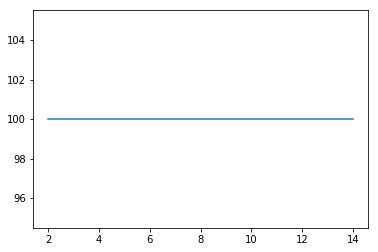

In [261]:
Accu = []
K=[]
for k in range(2,15):
        probab,Predicted = knn(k,5,X_htedata,X_htrdata,y_htrdata)
        Accu.append(getAccuracy(y_htedata,Predicted))
        K.append(k)
plt.plot(K,Accu)
plt.show()

In [72]:
probab,Predicted = knn(3,5,X_htedata,X_htrdata,y_htrdata)


************    K =  3   ******************
--> Calculating KNN...


In [73]:
T=np.full(20,0,dtype='int')
T = np.concatenate((T,np.full(20,1,dtype='int')))
T = np.concatenate((T,np.full(20,2,dtype='int')))
T = np.concatenate((T,np.full(20,3,dtype='int')))
T = np.concatenate((T,np.full(20,4,dtype='int')))

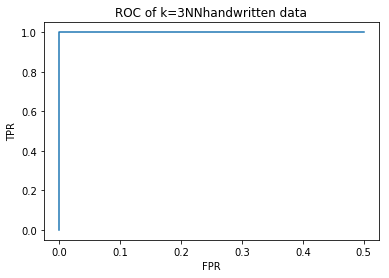

In [78]:
plt.title("ROC of k=3NNhandwritten data")
ROCmodf(probab,T,100)

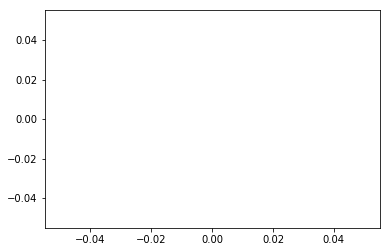

In [75]:
DETmodf(probab,T,100)

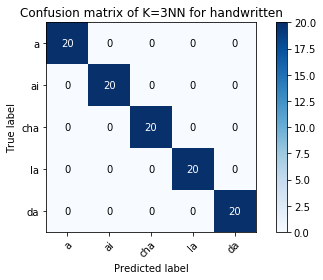

In [80]:

T=np.full(20,1,dtype='int')
T = np.concatenate((T,np.full(20,2,dtype='int')))
T = np.concatenate((T,np.full(20,3,dtype='int')))
T = np.concatenate((T,np.full(20,4,dtype='int')))
T = np.concatenate((T,np.full(20,5,dtype='int')))
func2(T,Predicted,classes=["1","2","3"],title='Confusion matrix of K=3NN for handwritten')